In [39]:
import sys, os
sys.path.append(sys.path[0][:sys.path[0].rfind('/')])
import torch
from mirtorch.prox import prox
from mirtorch.linear import *
from mirtorch.alg import *
from mirtorch.alg.fista import FISTA
from mirtorch.alg.pogm import POGM
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, scale
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import matplotlib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(70000, 784) (70000,)
Expected digit 5.0


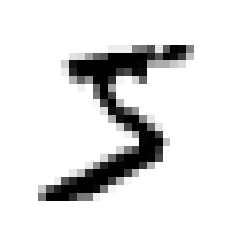

In [26]:
#Binary classification on MNIST digits using FISTA (specifically 3 and 5)
#get dataset
try:
    X,y = X_orig, y_orig
except:
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

y = y.astype(np.float64)
X_orig, y_orig = X, y
# print(len(X))
# print(len(X[y==3]))
# print(len(X[y==5]))
# print(len(X[(y==3) | (y==5)]))

def show_digit(X, y):
    digit_image = X.reshape(28,28)
    print(f'Expected digit {y}')
    plt.imshow(digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()
#reduce data to be binary classification for simplicity
# X, y = X[(y==3) | (y==5)], y[(y==3) | (y==5)]
# y = y - 4
print(X.shape, y.shape)
show_digit(X[0], y[0])
#create train/test sets
X = normalize(X, axis=0)
train_size = 56000
test_size = 14000
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=test_size)
X_train, X_test, y_train, y_test = torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train), torch.from_numpy(y_test)

In [48]:
"""
Let's solve 
A'*Ax = y with CG (because A'*A is PSD)
Let's solve
argmin_x ||Ax-y|| + g(x) with FISTA/FPGM and POGM where grad(||Ax-y||) is L-lipshitz continuous and g(x) is a proximal operator
"""
def score(x):
    # helper function to evaluate our results on the test data
    return mean_squared_error(y_test, torch.matmul(X_test, x))

class A(LinearMap):
    def __init__(self):
        self._A = X_train.clone()
        super().__init__([28*28], [train_size])
    def _apply(self, x):
        return torch.matmul(self._A, x)
    def _apply_adjoint(self, x):
        return torch.matmul(self._A.T, x)

class gradA:
    def __init__(self):
        self.A_mat = A()
    def __call__(self,x):
        return self.A_mat.H * (self.A_mat * x - y_train)

def loss(A, x, y):
    return .5*torch.nn.functional.mse_loss(A*x, y)

a_mat = A()
L = (torch.linalg.norm(X_train, ord=2)**2).item()

In [49]:
"""
Solve CG
"""
cg_loss = []
for i in range(1, 100, 5):
    cg = CG(A=a_mat.H*a_mat, max_iter=i).run(x0=torch.zeros(28*28,dtype=torch.double), b=a_mat.H(y_train))
    cg_loss.append(loss(a_mat, cg, y_train))

In [50]:
"""
Solve FISTA
"""
fsta_loss = []
fs_list = FISTA(f_grad=gradA(), 
               f_L=L, 
               g_prox=prox.L1Regularizer(1e-3), 
               max_iter=i).run_alg(x0=torch.zeros(28*28, dtype=torch.double), save_values = True)
for i in range(1, 100, 5):
    fsta_loss.append(loss(a_mat, fs_list[i-1], y_train))
    

In [51]:
"""
Solve POGM
"""
pogm_loss = []
pg_list = POGM(f_grad=gradA(), 
              f_L=L, 
              g_prox=prox.L1Regularizer(1e-3), 
              max_iter=i).run_alg(x0=torch.zeros(28*28, dtype=torch.double), save_values = True)
for i in range(1, 100, 5):
    pogm_loss.append(loss(a_mat, pg_list[i-1], y_train))

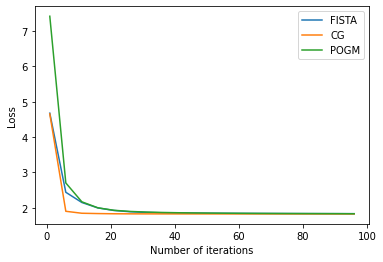

In [52]:
"""Plot loss vs number of iterations for each algorithm."""
plt.plot([i for i in range(1, 100, 5)], fsta_loss, label='FISTA')
plt.plot([i for i in range(1, 100, 5)], cg_loss, label='CG')
plt.plot([i for i in range(1, 100, 5)], pogm_loss, label='POGM')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.show()

In [33]:
"""
Verify that CG/FSTA/POGM is differentiable
"""
cg = CG(A=a_mat.H*a_mat, max_iter=10).run(x0=torch.zeros(28*28,dtype=torch.double,requires_grad=True), b=a_mat.H(y_train))
torch.sum(cg).backward()
fs = FISTA(f_grad=gradA(), f_L=L, g_prox=prox.L1Regularizer(1e-3), max_iter=10).run_alg(x0=torch.zeros(28*28, dtype=torch.double, requires_grad=True))
torch.sum(fs).backward()
pg = POGM(f_grad=gradA(), f_L=L, g_prox=prox.L1Regularizer(1e-3), max_iter=10).run_alg(x0=torch.zeros(28*28, dtype=torch.double, requires_grad=True))
torch.sum(pg).backward()

